In [1]:
from pynq import Overlay
from pynq import MMIO
import numpy as np
import struct
from time import time

from matplotlib import pyplot as plt

## CNN

### Load the overlay

In [2]:
from pynq import Overlay

overlay = Overlay('/home/xilinx/pynq/overlays/User_overlay/PYNQ_CNN.bit')

In [3]:
overlay.is_loaded()

True

### Check the clocks

In [4]:
from pynq import Clocks

print(f'CPU:   {Clocks.cpu_mhz:.6f}MHz')
print(f'FCLK0: {Clocks.fclk0_mhz:.6f}MHz')
print(f'FCLK1: {Clocks.fclk1_mhz:.6f}MHz')
print(f'FCLK2: {Clocks.fclk2_mhz:.6f}MHz')
print(f'FCLK3: {Clocks.fclk3_mhz:.6f}MHz')

CPU:   650.000000MHz
FCLK0: 100.000000MHz
FCLK1: 100.000000MHz
FCLK2: 100.000000MHz
FCLK3: 100.000000MHz


### Define the CNN ip

Here we define the ip and diplay the two memory mapped port addresses

In [5]:
ip = overlay.CNN_MNIST_0

In [6]:
ip.register_map

RegisterMap {
  Memory_in_V = Register(value=0),
  Memory_out_V = Register(value=37945396)
}

In [7]:
print("Memory_in_V.address: " + str(ip.register_map.Memory_in_V.address))
print("Memory_out_V.address: " + str(ip.register_map.Memory_out_V.address))

Memory_in_V.address: 1024
Memory_out_V.address: 2048


In [8]:
in_mmio = MMIO(ip.mmio.base_addr + ip.register_map.Memory_in_V.address, 196 * 4)
ou_mmio = MMIO(ip.mmio.base_addr + ip.register_map.Memory_out_V.address, 5 * 4)

### Load a fraction of the test dataset

In [9]:
X = np.load('./X_test.npy').astype(np.float32)
X = X[:5]

In [10]:
def encode_matrix(matrix):
    X_ca = np.reshape(matrix*2**5, (196,4))
    X_ca = X_ca.astype(np.uint32)
    X_enc = X_ca[:,0] + (X_ca[:,1]<<8) + (X_ca[:,2]<<16) + (X_ca[:,3]<<24)
    return X_enc


def decode(yi):
    return yi * 2**-10

def decode_pair(yab):
    ya = (yab & 0x0000ffff) * 2**-10
    ya = ya if ya < 32 else ya - 64
    yb = (yab & 0xffff0000) * 2**-26
    yb = yb if yb < 32 else yb - 64
    return ya, yb

def get_output(mmio):
    y = np.zeros(10)
    for i in range(5):
        yi = decode_pair(mmio.read(4 * i))
        y[2*i], y[2*i+1] = yi[0], yi[1]
    return y[:10]

#def decode_output(y):
    

def print_img(matrix, title="Label"):
    plt.imshow(matrix, cmap='gray')
    plt.title(title)
    plt.show()

    
def print_dt(timea, timeb, N):
    dt = (timeb - timea) 
    rate = N / dt
    print("Classified {} images in {} seconds ({} inferences / s)".format(N, dt, rate))
    print("----------------------------------------------------------------------------")
    print("{} s/inference ".format(1/rate))       

### Test
Siple test on the first five images

In [11]:
y = []
timea = time()
for Xi in X:
    X_new = encode_matrix(Xi)
    for i in range(196):
        in_mmio.write(4 * i, int(X_new[i]))
    y.append(get_output(ou_mmio))
timeb = time()
ips = X.shape[0]/(timeb-timea) #images per second
print('Throughput = %f image/s' % ips)

Throughput = 100.684238 image/s


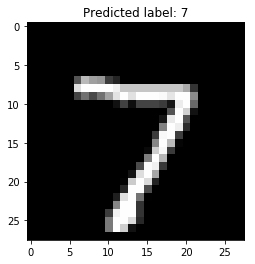

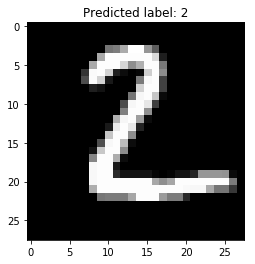

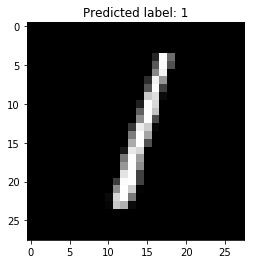

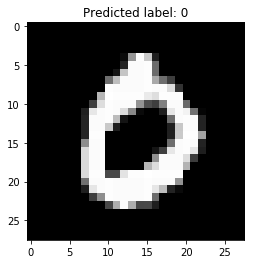

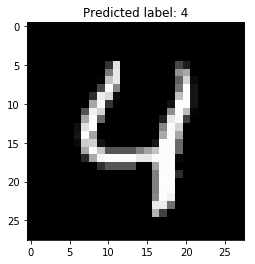

In [12]:
for i in range(X.shape[0]):
    img_title = ('Predicted label: %d' % np.argmax(np.array(y[i])))
    print_img(X[i], img_title)

### Whole dataset computation

In [13]:
N_callback = 500

X = np.load('./X_test.npy').astype(np.float32)
y = []
timea = time()
time0 = time()
for iXi, Xi in enumerate(X):
    X_new = encode_matrix(Xi)
    for i in range(196):
        in_mmio.write(4 * i, int(X_new[i]))
    y.append(get_output(ou_mmio))
    if (iXi % N_callback == 0) & (iXi != 0):
        time1 = time()
        print_dt(time0, time1, N_callback)
        time0 = time()

timeb = time()
print_dt(timea, timeb, X.shape[0])
np.save('y_pynq_CNN.npy', y)

Classified 500 images in 3.961265802383423 seconds (126.22227968119658 inferences / s)
----------------------------------------------------------------------------
0.007922531604766846 s/inference 
Classified 500 images in 3.953728199005127 seconds (126.46291672902922 inferences / s)
----------------------------------------------------------------------------
0.007907456398010253 s/inference 
Classified 500 images in 3.955095052719116 seconds (126.41921201268006 inferences / s)
----------------------------------------------------------------------------
0.007910190105438232 s/inference 
Classified 500 images in 3.957608938217163 seconds (126.33891013629095 inferences / s)
----------------------------------------------------------------------------
0.007915217876434327 s/inference 
Classified 500 images in 3.9686338901519775 seconds (125.98793787472613 inferences / s)
----------------------------------------------------------------------------
0.007937267780303955 s/inference 
Classifie

## DNN 

In [14]:
from pynq import Overlay

overlay = Overlay('/home/xilinx/pynq/overlays/User_overlay/PYNQ_DNN.bit')

In [15]:
overlay.is_loaded()

True

In [16]:
from pynq import Clocks

print(f'CPU:   {Clocks.cpu_mhz:.6f}MHz')
print(f'FCLK0: {Clocks.fclk0_mhz:.6f}MHz')
print(f'FCLK1: {Clocks.fclk1_mhz:.6f}MHz')
print(f'FCLK2: {Clocks.fclk2_mhz:.6f}MHz')
print(f'FCLK3: {Clocks.fclk3_mhz:.6f}MHz')

CPU:   650.000000MHz
FCLK0: 100.000000MHz
FCLK1: 100.000000MHz
FCLK2: 100.000000MHz
FCLK3: 100.000000MHz


In [17]:
ip = overlay.DNN_MNIST_0

In [18]:
ip.register_map

RegisterMap {
  Memory_in_V = Register(value=0),
  Memory_out_V = Register(value=9437208)
}

In [19]:
print("Memory_in_V.address: " + str(ip.register_map.Memory_in_V.address))
print("Memory_out_V.address: " + str(ip.register_map.Memory_out_V.address))

Memory_in_V.address: 1024
Memory_out_V.address: 2048


In [20]:
in_mmio = MMIO(ip.mmio.base_addr + ip.register_map.Memory_in_V.address, 196 * 4)
ou_mmio = MMIO(ip.mmio.base_addr + ip.register_map.Memory_out_V.address, 5 * 4)

In [21]:
X = np.load('./X_test.npy').astype(np.float32)
X = X[:5]

In [22]:
y = []
timea = time()
for Xi in X:
    X_new = encode_matrix(Xi)
    for i in range(196):
        in_mmio.write(4 * i, int(X_new[i]))
    y.append(get_output(ou_mmio))
timeb = time()
ips = X.shape[0]/(timeb-timea) #images per second
print('Throughput = %f image/s' % ips)

Throughput = 76.740328 image/s


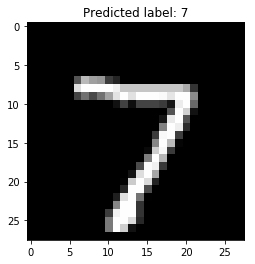

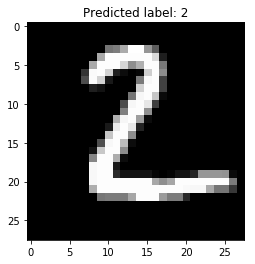

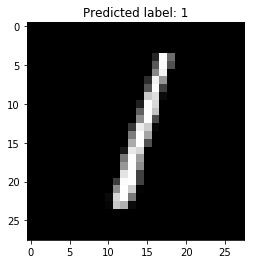

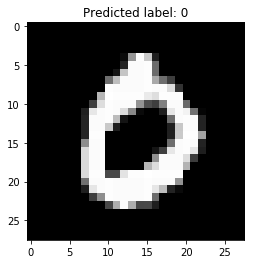

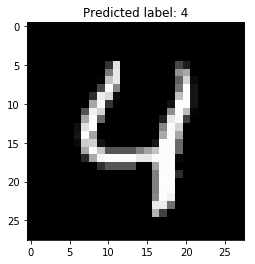

In [23]:
for i in range(X.shape[0]):
    img_title = ('Predicted label: %d' % np.argmax(np.array(y[i])))
    print_img(X[i], img_title)

In [24]:
N_callback = 500

X = np.load('./X_test.npy').astype(np.float32)
y = []
timea = time()
time0 = time()
for iXi, Xi in enumerate(X):
    X_new = encode_matrix(Xi)
    for i in range(196):
        in_mmio.write(4 * i, int(X_new[i]))
    y.append(get_output(ou_mmio))
    if (iXi % N_callback == 0) & (iXi != 0):
        time1 = time()
        print_dt(time0, time1, N_callback)
        time0 = time()

timeb = time()
print_dt(timea, timeb, X.shape[0])
np.save('y_pynq_DNN.npy', y)

Classified 500 images in 3.9998793601989746 seconds (125.0037701074883 inferences / s)
----------------------------------------------------------------------------
0.007999758720397949 s/inference 
Classified 500 images in 3.842712163925171 seconds (130.11643304797275 inferences / s)
----------------------------------------------------------------------------
0.007685424327850342 s/inference 
Classified 500 images in 3.84317946434021 seconds (130.10061191244398 inferences / s)
----------------------------------------------------------------------------
0.00768635892868042 s/inference 
Classified 500 images in 3.834834337234497 seconds (130.38372874291528 inferences / s)
----------------------------------------------------------------------------
0.007669668674468995 s/inference 
Classified 500 images in 3.840297222137451 seconds (130.19825578024077 inferences / s)
----------------------------------------------------------------------------
0.007680594444274902 s/inference 
Classified 5